In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Set random seeds for reproducibility
torch.manual_seed(42)


In [43]:
#1. Check for GPU
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device:{device}")

Using device:cuda


In [44]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df.shape

(60000, 785)

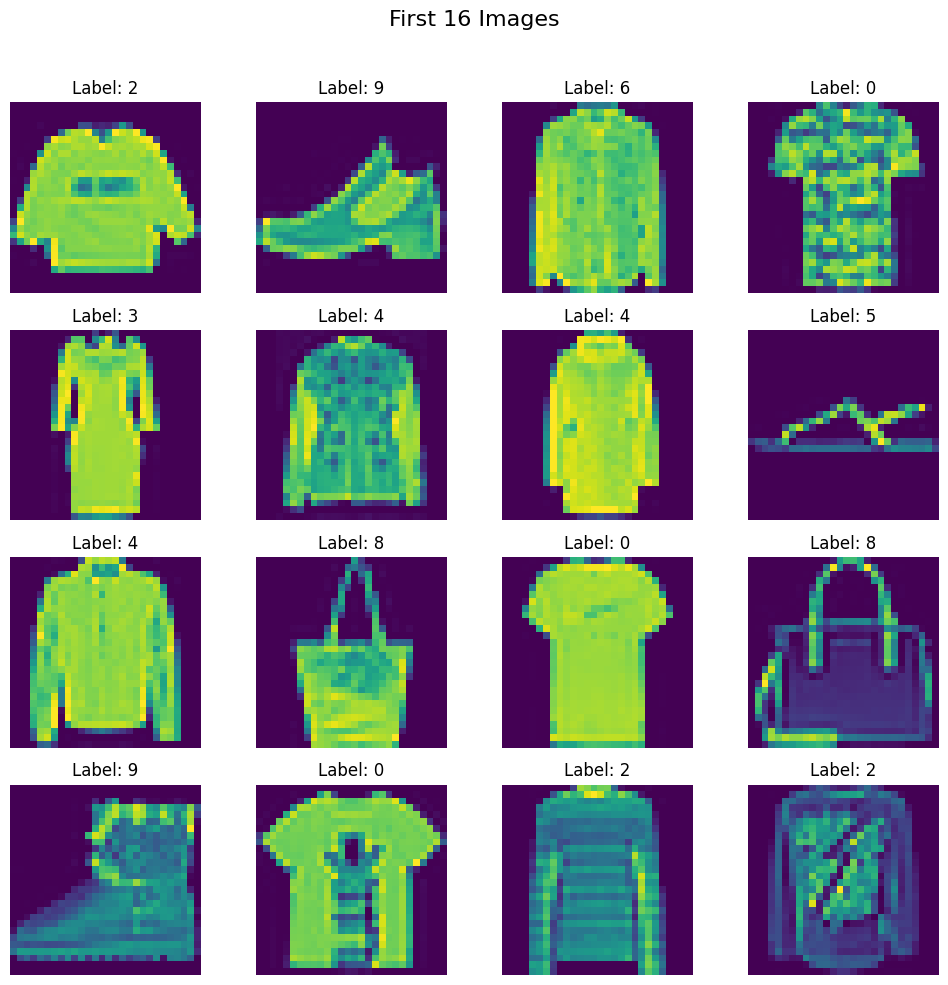

In [46]:
# Create a 4x4 grid of images

fig,axes = plt.subplots(4,4,figsize = (10,10))
fig.suptitle("First 16 Images", fontsize = 16)

# PLot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28) # Reshape to 28x28
  ax.imshow(img)  # Display in grayScale
  ax.axis("off")  # Remove axis for a cleaner look
  ax.set_title(f"Label: {df.iloc[i,0]}") # SHow the look

plt.tight_layout(rect=[0,0,1,0.96])  # Adjust layout to fit the titile

plt.show()

In [49]:
# Train test split
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [50]:
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=0.2,random_state=42)

In [51]:
## Scaling the featurees
X_train = X_train/255.0
X_test = X_test/255.0

In [52]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

In [53]:
# Create a CustomDataset Class

class CustomDataset(Dataset):

  def __init__(self, features, labels):
    # Convert to PyTorch tensors
    self.features = torch.tensor(features,dtype = torch.float32).reshape(-1,1,28,28) #-1 batchsize32 dont know, 1-imagechannel-gray,if rgb=3, 28,28- dimension
    self.labels =  torch.tensor(labels,dtype = torch.long)

  def __len__(self):

    return len(self.features)

  def __getitem__(self,index):
    return self.features[index], self.labels[index]


In [54]:
## Create Train_datasets object

train_dataset = CustomDataset(X_train,y_train)

In [55]:
len(train_dataset)

48000

In [56]:
## Create Test_datasets object

test_dataset = CustomDataset(X_test,y_test)

In [57]:
len(test_dataset)

12000

In [58]:
# Create Train and Test Loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle= False)

In [59]:
# len(train_loader)

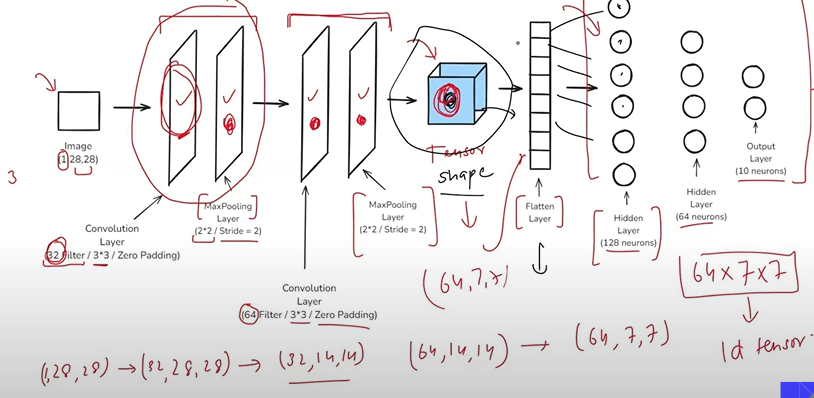

## # CNN Architecture

In [75]:
class MyNN(nn.Module):

  def __init__(self, input_features):
    super().__init__()
    # CNN Architecture
    #Feature Extraction  - convolution plus pooling layer
    self.features = nn.Sequential(
        nn.Conv2d(input_features, 32, kernel_size =3, padding='same'), # Changed 'kernal_size' to 'kernel_size'
        nn.ReLU(),
        nn.BatchNorm2d(32), # Improve the trining
        nn.MaxPool2d(kernel_size = 2, stride = 2), # Changed 'kernal_size' to 'kernel_size'
# input_features from first channel to inputas 32 to 2nd convolution layer
        nn.Conv2d(32, 64, kernel_size =3, padding='same'), # Changed 'kernal_size' to 'kernel_size'
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size = 2, stride = 2),    # Changed 'kernal_size' to 'kernel_size'
    )
    # Classification
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(64,10),
    )

  def forward(self, x):
    x =  self.features(x)
    x =  self.classifier(x)

    return x

In [76]:
learning_rate = 0.01
epochs = 100

In [77]:
model = MyNN(1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [78]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.6448676546017329
Epoch: 2 , Loss: 0.38033816071848076
Epoch: 3 , Loss: 0.3218301895260811
Epoch: 4 , Loss: 0.28560796118403475
Epoch: 5 , Loss: 0.2647124948774775
Epoch: 6 , Loss: 0.2410695149699847
Epoch: 7 , Loss: 0.22780714799215396
Epoch: 8 , Loss: 0.21408311798547705
Epoch: 9 , Loss: 0.2029215091386189
Epoch: 10 , Loss: 0.19178014335532984
Epoch: 11 , Loss: 0.17738245120830834
Epoch: 12 , Loss: 0.16646366197243334
Epoch: 13 , Loss: 0.159864256342873
Epoch: 14 , Loss: 0.14670255806452284
Epoch: 15 , Loss: 0.1454653024530659
Epoch: 16 , Loss: 0.13562379027126978
Epoch: 17 , Loss: 0.1299026927134643
Epoch: 18 , Loss: 0.1250938086003686
Epoch: 19 , Loss: 0.11499804988006751
Epoch: 20 , Loss: 0.11119108925294131
Epoch: 21 , Loss: 0.10414703521388582
Epoch: 22 , Loss: 0.09829700034499789
Epoch: 23 , Loss: 0.09225069975907293
Epoch: 24 , Loss: 0.09171606386173517
Epoch: 25 , Loss: 0.08578310421198451
Epoch: 26 , Loss: 0.07980523180092375
Epoch: 27 , Loss: 0.07998453105

In [79]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [80]:


# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9241666666666667


In [81]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9996458333333333
